# Irish Citizenship Data
----------------------------------

This notebook goal is to give some insights on the Irish citizenship application process during years 2018-2019
1. [Crawl data:](#1.-Crawl-Data) source: www.immigrationboards.com 

2. [Clean data:](#2.-Clean-Data) format dates, remove outliers, duplicates, empty records
3. [Analyze & Visualize](#3.-Analyze-&-Visualize)

    1. [Application Timeline](#3.1-Applications-Timeline) What is the major event that affected applications numbers?
    2. [Most frequent words (Wordcloud)](#3.2-Most-frequent-words) What are the common words/issues related to the applications
    3. [Types & Origins of Applications](#3.3-Types-&-Origins-of-applications) What are the origins of the applicants and what are they based on?
    4. [Processing Time for each stage(Gantt Chart)](#3.4-Processing-time-(Gantt-Chart)) How do stages of process compare to each other? 

In [1]:
import requests
from bs4 import BeautifulSoup
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
import matplotlib.dates as mdates
from matplotlib import rcParams
import plotly.figure_factory as ff
from collections import Counter 
from wordcloud import WordCloud,STOPWORDS


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['font.size'] = '14'


## 1. Crawl Data
--------------------

In [2]:
# sources for data
immigration_url = 'https://www.immigrationboards.com/ireland/'
url2019 = 'https://www.immigrationboards.com/ireland/2019-citizenship-applications-timelines-only-t274270.html'
url2018 = 'https://www.immigrationboards.com/ireland/2018-citizenship-application-timelines-only-t246311.html'


### Get all pages in pagination

In [3]:
urls = [url2018,url2019]
pagesList =[url2018,url2019]
formatlink=['https://www.immigrationboards.com/ireland/2018-citizenship-application-timelines-only-t246311-%s.html',\
'https://www.immigrationboards.com/ireland/2019-citizenship-applications-timelines-only-t274270-%s.html']

for i,year in enumerate(urls):
    #print(year)
    r = requests.get(year)
    soup = BeautifulSoup(r.content, 'html.parser')
    paging = soup.find_all("div",{"class":"pagination"})[0].find_all("a")
    start_page = paging[1].text
    last_page = paging[len(paging)-2].text

    pages = list(range(1,int(last_page)+1))
    for page in pages:
        pagen = page *20
        url = formatlink[i]%(pagen)
        #print(url)
        pagesList.append(url)

### Extract Data from posts 
Unstructred (regex) > Structured data (DF)

### Sample

"Application Based On: EU Citizen with 5 years residence\

Applied On: 09/01/2019\

Application received On: 10/01/2019\

Second Letter: 02/02/19 (Processing Team 1)\

Approval: 19/11/2019 \

Bank draft and photos sent on 21/11/19 received on 22/11/2019\

Date of Ceremony: PENDING\

Second Letter - June 2019 \

Approval letter - January 2020 , asking for 950 euro Bank Draft and GNIB card ."


In [4]:
# create dataframe with extracted data

df = pd.DataFrame(columns = ['text','based_on','applied','received','acknowledgement','second','third','cermony'])
for page in pagesList:
    #print('processing page: ', page)
    r = requests.get(page)
    soup = BeautifulSoup(r.content, 'html.parser')
    
    # remove cited replies
    for cite in soup.find_all('blockquote'):
        cite.decompose();
        
    for div in soup.find_all('div',attrs={'class':'content'}):
        stringdiv =str(div.text.strip())
        #stringdiv = stringdiv.replace('\n',' ')
        #print(stringdiv)
        #print(str(div.string))
        dateregEX = '(?:\d{1,2}[-/th|st|nd|rd\s]*)?(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)?[a-z\s,.]*(?:\d{1,2}[-/th|st|nd|rd)\s,]*)+(?:\d{2,4})+|pending|$'

        based_on=re.findall('Based On*(.+)|$',stringdiv,re.IGNORECASE)[0]
        applied=re.findall('Applied.*[:]*'+dateregEX,stringdiv,re.IGNORECASE)[0]
        if(applied in['Pending','pending','']):
            applied=re.findall('sent.*[:]*'+dateregEX,stringdiv,re.IGNORECASE)[0]
        received=re.findall('received.*[:]*'+dateregEX,stringdiv,re.IGNORECASE)[0]
        acknow=re.findall('Acknowledgement.*[:]*'+dateregEX,stringdiv,re.IGNORECASE)[0]
        second=re.findall('Second Letter.*[:]*'+dateregEX,stringdiv,re.IGNORECASE)[0]
        third=re.findall('Approval.*[:]*'+dateregEX,stringdiv,re.IGNORECASE)[0]
        cermony=re.findall('Ceremony.*[:]*'+dateregEX,stringdiv,re.IGNORECASE)[0]
        temp= [based_on,applied,received,acknow,second,third,cermony]
        
        #if all items are empty
        if not any(temp):
            continue
        else:
            record=[stringdiv,based_on,applied,received,acknow,second,third,cermony]
        #print(record)
        f = pd.DataFrame(data=[record], columns = ['text','based_on','applied','received','acknowledgement','second','third','cermony'])
        df = df.append(f,ignore_index=True)
print('------------------------------')
print('number of applications ',df.index.size)

------------------------------
number of applications  405


In [5]:
#keep backup 
dfkeep = pd.DataFrame(df)


## 2. Clean Data
---------------------

In [6]:
df= df.apply(lambda x:x.str.replace(':',''))
df= df.apply(lambda x:x.str.replace('\n',' '))

df = df.apply(lambda x: x.str.strip())
df['based_on'] = df['based_on'].map(lambda x: x.replace('Application Based On',''))
df= df.apply(lambda x:x.str.replace('pending','Pending'))
df= df.apply(lambda x:x.str.replace('PENDING','Pending'))
df = df.apply(lambda x: x.str.strip())


### Extract Dates only

In [7]:
dater = '(\s+(?:\d{1,2}[-|\/|th|st|nd|rd|\s*]*)?(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)?[a-z\s,.]*(?:\d{1,2}[-/th|st|nd|rd)\s,]*)+(?:\d{2,4})+)'


df['cermony']=df['cermony'].str.extract(dater, expand=True)
df['third']=df['third'].str.extract(dater, expand=True)
df['second']=df['second'].str.extract(dater, expand=True)
df['acknowledgement']=df['acknowledgement'].str.extract(dater, expand=True)
df['applied']=df.applied.str.extract(dater, expand=True)
df['received']=df['received'].str.extract(dater, expand=True)


### fill missing values

In [8]:
df.fillna(value='Pending',inplace=True)

### Format dates

we have several datatypes in the data

(29.03.2019| 6 March, 2019  | 25 Mar 2019 |25 March 2019 |15th/07/2019 |7Jan2019 |March 5, 2019)

goal: convert all to one format > %d/%B/%Y 

In [9]:
#fix: some applicants mispelled february
df = df.apply(lambda x: x.str.replace("Febuary","February"))
df = df.apply(lambda x: x.str.replace("febuary","February"))

In [10]:
# format date from data observations
df['applied'] = df['applied'].map(lambda x: x.replace('.','/').replace(', ','/').replace(',','/'))
df['received'] = df['received'].map(lambda x: x.replace('.','/').replace(', ','/').replace(',','/'))
df['acknowledgement'] = df['acknowledgement'].map(lambda x: x.replace('.','/').replace(', ','/').replace(',','/'))
df['second'] = df['second'].map(lambda x: x.replace('.','/').replace(', ','/').replace(',','/'))
df['third'] = df['third'].map(lambda x: x.replace('.','/').replace(', ','/').replace(',','/'))
df['cermony'] = df['cermony'].map(lambda x: x.replace('.','/').replace(', ','/').replace(',','/'))



In [11]:
### convert to date format

df['applied']= pd.to_datetime(df.applied,infer_datetime_format=False,errors='coerce',dayfirst=True).dt.strftime('%d/%B/%Y')
df['received']= pd.to_datetime(df.received,infer_datetime_format=False,errors='coerce',dayfirst=True).dt.strftime('%d/%B/%Y')
df['acknowledgement']= pd.to_datetime(df.acknowledgement,infer_datetime_format=False,errors='coerce',dayfirst=True).dt.strftime('%d/%B/%Y')
df['second']= pd.to_datetime(df.second,infer_datetime_format=False,errors='coerce',dayfirst=True).dt.strftime('%d/%B/%Y')
df['third']= pd.to_datetime(df.third,infer_datetime_format=False,errors='coerce',dayfirst=True).dt.strftime('%d/%B/%Y')
df['cermony']= pd.to_datetime(df.cermony,infer_datetime_format=False,errors='coerce',dayfirst=True).dt.strftime('%d/%B/%Y')

In [12]:
df['applied']=pd.to_datetime(df['applied'])
df['received']=pd.to_datetime(df['received'])
df['acknowledgement']=pd.to_datetime(df['acknowledgement'])
df['second']=pd.to_datetime(df['second'])
df['third']=pd.to_datetime(df['third'])
df['cermony']=pd.to_datetime(df['cermony'])


In [13]:
df.head()

,text,based_on,applied,received,acknowledgement,second,third,cermony
0,Application Based On Applied On Application received On Acknowledgement Second Letter Awaiting On Approval Date of Ceremony,,NaT,NaT,NaT,NaT,NaT,NaT
1,"Application Based On Foreign Birth Registry (FBR) Applied On Application received On January 3, 2018 Acknowledgement January 3, 2018 (via Fedex Signature Delivery only) Second Letter None Yet Aw...",Foreign Birth Registry (FBR),NaT,2018-01-03,2018-01-03,NaT,NaT,NaT
2,Application Based On 5+ years of residency (I'm an EU citizen already) Applied On 8th Jan 2018 Application received On 9th Jan 2018 (as per AnPost tracking record) Acknowledgement Received on 16th...,5+ years of residency (I'm an EU citizen already),2018-01-08,2018-01-09,2018-01-16,NaT,NaT,NaT
3,Hi everyone. New member. Application Based On Conferral Applied On 23rd January 2018 Application received On 23rd January 2018 Acknowledgement N/A Second Letter N/A Awaiting On Approval N/A Date...,Conferral,2018-01-23,2018-01-23,NaT,NaT,NaT,NaT
4,Application Based on 10 Years Stamp 4 EU Fam in October 2016 on Retention basis Acknowledgement Letter Received November 2016 2nd Stage Letter Received March 2017 Decision Waiting,10 Years Stamp 4 EU Fam in October 2016 on Retention basis,NaT,2016-11-01,2016-11-01,NaT,NaT,NaT


### remove duplicates 

In [14]:
#duplicates
ids = df["text"]
dps = df[ids.isin(ids[ids.duplicated()])]

In [15]:
df.drop_duplicates(inplace=True)
df.index.size

389

### Find outliers in date
remove rows where date is not between 2017 and 2020 (allowing one year before/after our focus range of 2018-2019)

In [16]:
f=pd.to_datetime('01-01-2017',infer_datetime_format=False,errors='coerce',dayfirst=True)
e=pd.to_datetime('30-12-2020',infer_datetime_format=False,errors='coerce',dayfirst=True)

df = df[( (df.applied.between(f,e))| (df.applied.isna()))]
df = df[( (df.received.between(f,e))| (df.received.isna()))]
df = df[( (df.acknowledgement.between(f,e))| (df.acknowledgement.isna()))]
df = df[( (df.second.between(f,e))| (df.second.isna()))]
df = df[( (df.third.between(f,e))| (df.third.isna()))]
df = df[( (df.cermony.between(f,e))| (df.cermony.isna()))]
df.index.size

386

In [17]:
# save dataframe
df.to_csv('Irishctzapp.csv',index=False)

### Show numbers 

In [18]:
print('all applications',df.index.size)
print('empty application date',df[df.applied.isna()].index.size)

print('Pending applications in first stage (acknowledgment)',df[df.acknowledgement.isna()].index.size)
print('Pending applications in second stage',df[df.second.isna()].index.size)
print('Pending applications in third stage',df[df.third.isna()].index.size)
print('Pending applications in last stage / waiting cermony',df[df.cermony.isna()].index.size)
print('FINISHED applications with cermony dates :',df[~df.cermony.isna()].index.size)


all applications 386
empty application date 98
Pending applications in first stage (acknowledgment) 207
Pending applications in second stage 281
Pending applications in third stage 311
Pending applications in last stage / waiting cermony 350
FINISHED applications with cermony dates : 36


## 3. Analyze & Visualize
------------------------------

### 3.1 Applications Timeline 

#### How long does each stage lasts on average


In [19]:
t1=df.received - df.applied 
t1.describe()

count                        232
mean      8 days 10:45:31.034482
std      40 days 05:59:17.912811
min              0 days 00:00:00
25%              1 days 00:00:00
50%              1 days 00:00:00
75%              2 days 00:00:00
max            504 days 00:00:00
dtype: object

> Acknowledgement is a better indicator than recieved as not all applications have that date

In [20]:
t2 = df.acknowledgement - df.applied
tt2=t2.describe()
tt2

count                        166
mean     29 days 22:33:15.180722
std      48 days 10:34:07.638534
min            -5 days +00:00:00
25%              5 days 00:00:00
50%             14 days 00:00:00
75%             31 days 18:00:00
max            444 days 00:00:00
dtype: object

#### Median can be better indicator than mean in case of outliers

In [21]:
t2.median()

Timedelta('14 days 00:00:00')

In [22]:
t3 = df.second - df.acknowledgement
tt3=t3.describe()
tt3

count                          79
mean      92 days 08:30:22.784810
std      126 days 16:51:41.431089
min           -316 days +00:00:00
25%               0 days 00:00:00
50%              52 days 00:00:00
75%             164 days 00:00:00
max             395 days 00:00:00
dtype: object

In [23]:
t3.median()

Timedelta('52 days 00:00:00')

In [24]:
#delete outlier
df = df[df.text!=df.iloc[129].text]

In [25]:
t4 = df.third - df.second
tt4=t4.describe()
tt4

count                          41
mean     159 days 21:39:30.731707
std       87 days 13:19:18.028854
min               0 days 00:00:00
25%              92 days 00:00:00
50%             175 days 00:00:00
75%             232 days 00:00:00
max             290 days 00:00:00
dtype: object

In [26]:
t4.median()

Timedelta('175 days 00:00:00')

In [27]:
t5 = df.cermony - df.third
tt5=t5.describe()
tt5

count                         21
mean     44 days 12:34:17.142857
std      56 days 19:05:56.364797
min              0 days 00:00:00
25%             20 days 00:00:00
50%             31 days 00:00:00
75%             46 days 00:00:00
max            275 days 00:00:00
dtype: object

In [28]:
t5.median()

Timedelta('31 days 00:00:00')

In [29]:
process_time = df.cermony - df.applied
tt6=process_time.describe()
tt6

count                          26
mean     310 days 22:09:13.846153
std      146 days 17:58:35.026317
min              19 days 00:00:00
25%             208 days 00:00:00
50%             333 days 00:00:00
75%             408 days 06:00:00
max             560 days 00:00:00
dtype: object

In [30]:
process_time.median()

Timedelta('333 days 00:00:00')

In [31]:
stages_labels = ['acknowledgement','second letter','awaiting approval from minister','invitation to cermony','full process']
stages = [tt2,tt3,tt4,tt5,tt6]

print('Average time between stages')
for i,stage in enumerate(stages):
    print(' .  ',stages_labels[i],stage['mean'])

Average time between stages
 .   acknowledgement 29 days 22:33:15.180722
 .   second letter 92 days 08:30:22.784810
 .   awaiting approval from minister 159 days 21:39:30.731707
 .   invitation to cermony 44 days 12:34:17.142857
 .   full process 310 days 22:09:13.846153


> Processing time for 24 applications from start to end takes on average 310 days with the max case 560 days


#### PLOT

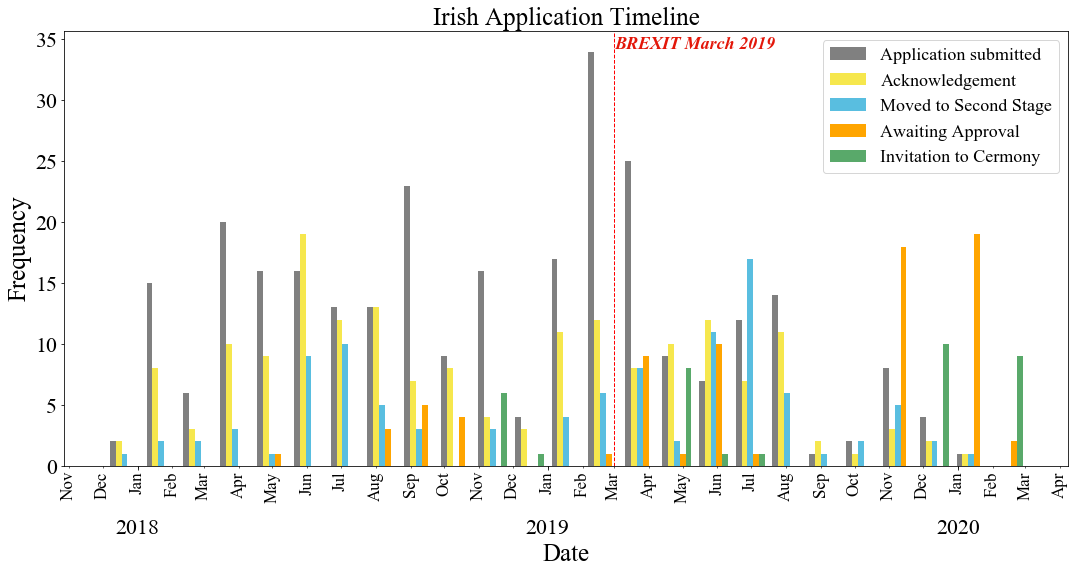

In [45]:
years = mdates.YearLocator()
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%b') 
yearsFmt = mdates.DateFormatter('\n\n%Y')

fig, ax = plt.subplots(figsize=(18, 8))

colors = [ 'grey', '#F6E74D','#59BEE0','orange','#59A96A']
          #'white','#E3170A','#59A96A']
labels = ['Application submitted','Acknowledgement','Moved to Second Stage','Awaiting Approval','Invitation to Cermony']
x1= list(df.applied[~df.applied.isna()])
#x2= list(df.received[~df.received.isna()])
x3= list(df.acknowledgement[~df.acknowledgement.isna()])
x4= list(df.second[~df.second.isna()])
x5= list(df.third[~df.third.isna()])
x6= list(df.cermony[~df.cermony.isna()])


n, bins, patches= ax.hist([x1,x3,x4,x5,x6],bins=25,histtype='bar', color=colors, label=labels)

ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)


plt.xlabel('Date',fontsize=25)
plt.ylabel('Frequency',fontsize=25)
plt.legend(fontsize=18)
plt.title('Irish Application Timeline',fontsize=25)
plt.figtext(.55, .85, "BREXIT March 2019",color='#E3170A',fontsize=18,fontstyle='italic')
## red for BREXIT
#patches[0][13].set_fc('#E3170A')
ax.tick_params(axis = 'both', which = 'major', labelsize = 22)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 17,labelrotation=90)
ax.axvline(pd.Timestamp('1/MAR/2019'), color='red', linestyle='dashed', linewidth=1)
plt.savefig('appsTimeline.png')
plt.show()



> **Feb 2019 has highest application rate just before Brexit in March 2019**

### 3.2 Most frequent words
What are applicants common issues?

In [33]:
#covert text to one string
text=' '.join(df.text.str.strip().str.lower())
text =text.replace('\n',' ')
text =text.replace('stamp 1 + stamp 4','stamp1stamp4')


In [34]:
#define noise words based on context
noise = ["application","based","on", "applied","application","received","second","letter","awaiting"\
,"approval","received","date","of","ceremony","pending",'acknowledgment','acknowledgement','sent','years','irish citizen'\
'non','eu','non-eu','irish citizen','non']

#add to predfined list of stop words
cstopwords = set(STOPWORDS)
cstopwords.update(noise)

In [35]:
#color function
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 100.0 / 255.0)
    s = int(100.0 * 180.0 / 255.0)
    l = int(100.0 * float(random_state.randint(40, 100)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

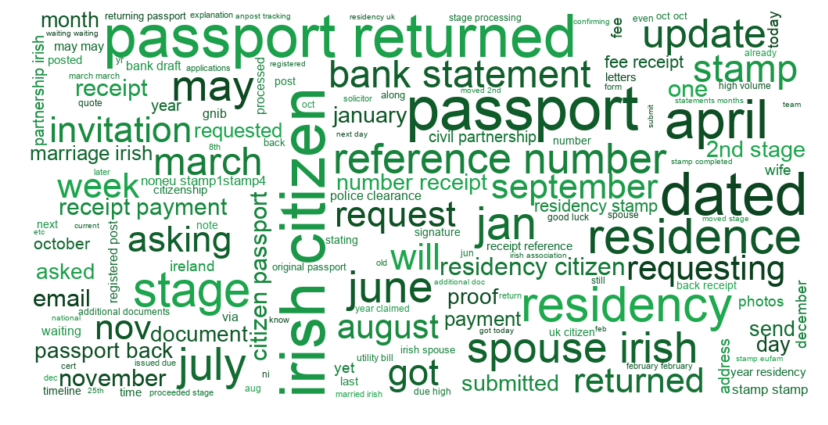

In [46]:
#plot word cloud
textwordcloud = WordCloud(background_color="white", max_words=150,font_path='Arial',
               stopwords=cstopwords,color_func=random_color_func,
                          max_font_size=80,width=1000,height=500,min_font_size=5, random_state=20).generate(text)
plt.figure(figsize=[14,16])
plt.imshow(textwordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('appswordcloud.png')
plt.show()

irish citizen, passport, non-eu, stamp 4, number receipt, years residence, reference number, receipt payment, 

3.3 Types & Origins of applications
========================================

Applications are based on one of the following:
    1. Marriage/ Partnership with Irish (Spouse of Irish /married/ marriage)
    2. Residency in Ireland 5+ years (Residence/stamp/resident/living/working/residency, Non-EU)
    3. Irish Descendant (Grandchild of an Irish Citizen)
Origins of applications are :
    * EU
    * Non-EU
    * UK
    * N/A


In [37]:
basedunique=df.based_on.unique()

In [38]:
marriage=[]
residency=[]
stamp=[]
irish=[]
origins=[]
for row in df.based_on:
    stringbased = str(row)
    #print(stringbased)
    regex1 = '(?:Spouse of an Irish Citizen|married|marriage|spouse|partner)'
    regex2 = '(?:Residence|resident|living|working|residency)'
    regex3 = '(stamp.*\w)'
    regex4 = '(?:Grandchild|granparent|Associations|mother|birth)'
    regex5 = '(Non[\s|-]*EU|UK|British|EU|\bUS\b|American)'
    result1=re.findall(regex1,stringbased, re.IGNORECASE)
    if(result1):
        marriage.append(True)
    else:
        marriage.append(False)
    result2=re.findall(regex2,stringbased, re.IGNORECASE)
    if(result2):
        temp=True
    else:
        temp=False
    result3=re.findall(regex3,stringbased, re.IGNORECASE)
    if(result3):
        stamp.append(result3[0])
        temp = True
    else:
        stamp.append('')
    residency.append(temp)

        
    result4=re.findall(regex4,stringbased, re.IGNORECASE)
    if(result4):
        irish.append(True)
    else:
        irish.append(False)
    result5 = re.findall(regex5,stringbased, re.IGNORECASE)
    if(result5):
        origins.append(result5[0])
    else:
        origins.append('N/A')
   

In [39]:
df['marriage']=marriage
df['residency']=residency
df['stamp'] = stamp
df['irish_descent'] =irish
df['origins']=origins

In [40]:
#clean
df.origins=df.origins.replace(['Eu','eu'],'EU')
df.origins = df.origins.replace(['noneu','NonEU','Non Eu','NON EU','non-eu','Non-EU','non-EU','NON-EU','Non EU','Non-Eu','non EU','non eu','Non -EU','non Eu'],'Non-EU')
df.origins=df.origins.replace(['uk','Uk','british','British'],'UK')
df.origins.unique()

array(['N/A', 'EU', 'UK', 'Non-EU'], dtype=object)

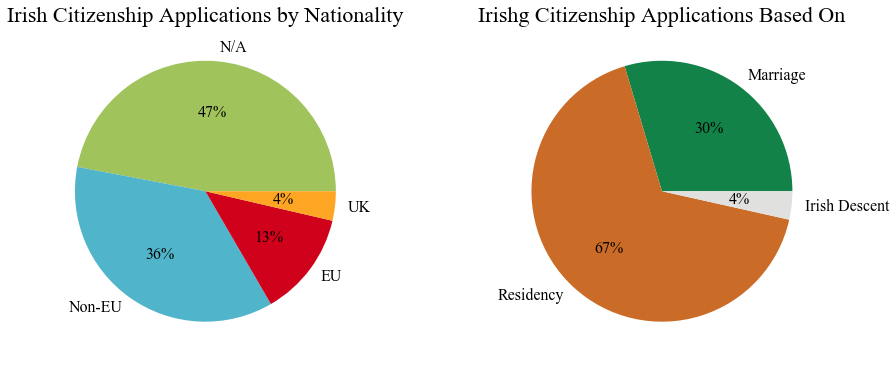

In [48]:
fig1, ax1 = plt.subplots(nrows=1,ncols=2,figsize=(15, 6))


c = Counter(df.origins)
labels = list(c.keys())
values = list(c.values())

ax1[0].pie(values, labels=labels,colors=['#A0C35C','#50B4CA','#D0021B','#FEA623'],autopct='%1.0f%%',textprops={'fontsize': 16})

ax1[0].set_title ("Irish Citizenship Applications by Nationality",fontsize=22)

labels = ['Marriage','Residency','Irish Descent']
values = [df['marriage'].value_counts()[True],\
          df['residency'].value_counts()[True],\
          df['irish_descent'].value_counts()[True]]

ax1[1].pie(values, labels=labels,colors=['#138248','#CA6C28','#E0E0DF'],autopct='%1.0f%%',textprops={'fontsize': 16})

ax1[1].set_title ("Irishg Citizenship Applications Based On",fontsize=22)
plt.savefig('appsbreakdown.png')

plt.show()


### 3.4 Processing time (Gantt Chart)

visualize processing time and compare stages for applications starting in the same time range

In [42]:
#change format of data to fit in plotly defined dictionary style
def format_for_plot(dframe):
    #sort by application date
    dframe.sort_values(by=['applied','received','acknowledgement',],inplace=True) 

    #get only datetime columns
    times = dframe.iloc[:,2:8] 
    #fill na values
    times=times.fillna('pending')
    #convert to dictionary
    dictTime = times.to_dict('record')

    applications=[]
    for i,row in enumerate(dictTime):
        if(row['applied']!='pending' and row['received']!='pending' ):
            d = dict({'Task':i,'Start':row['applied'],'Finish':row['received'], 'Resource':'applied'})
            applications.append(d)

        if(row['acknowledgement']!='pending' and row['received']!='pending' ):

            d = dict({'Task':i,'Start':row['received'],'Finish':row['acknowledgement'], 'Resource':'received'})
            applications.append(d)

        if(row['acknowledgement']!='pending' and row['second']!='pending' ):
            d = dict({'Task':i,'Start':row['acknowledgement'],'Finish':row['second'], 'Resource':'acknowledgement'})
            applications.append(d)
        if(row['third']!='pending'  and row['second']!='pending' ):

            d = dict({'Task':i,'Start':row['second'],'Finish':row['third'], 'Resource':'second'})
            applications.append(d)
        if(row['third']!='pending' and row['cermony']!='pending' ):

            d = dict({'Task':i,'Start':row['third'],'Finish':row['cermony'], 'Resource':'third'})
            applications.append(d)
    print('result',len(applications))
    return applications
    

In [43]:
dfapplications=format_for_plot(df)
len(dfapplications)

result 523


523

In [52]:
#plot
colors = {'applied': '#31393C',
          'received': '#FF4236',
          'acknowledgement': '#2176FF',
         'second':'#FFB945',
          'third':'#057044'}
         
fig = ff.create_gantt(dfapplications,group_tasks=True,colors=colors,index_col='Resource',\
                      width=800,height=2000,show_colorbar=True,bar_width=0.4, showgrid_x=True, showgrid_y=False\
                     ,title='Applications Timeline 2018')
fig.write_image("gantt.png")
fig.show()


Some replications in the graph is due to new entries with updates. 

todo next merge in one